### Demonstration of Gene-CellType Association Uses

Team TYPER has written a script to generate Gene-CellType Assocations from texting mining pubmed literature. This notebook will demonstrate one of these association's potential use in single cell (sc) biology. We'll load in our association scores from the script and attempt to classify scRNA-seq datasets, aka labeling each individual cells. In our case we have the ground truth of each single cell, so we can evaulate the effectiveness of our approach.

The scores used in this demo note-book was generated by running: 
`python gene2vec.py -q pbmcs -d <path_to_database> -g <path_to_genes> -k 325472302_b_lymphocytes cd34 treg 325470302_monocytes nk_cell`



In [1]:
# load libraries
import pickle
import umap
import umap.plot
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io
import scanpy as sc
from scipy import sparse
import pandas as pd

# import helper utils for data-analysis
import utils

/Users/sjwu/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/sjwu/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


### Load in our scRNA-seq data

The data we'll be analyzing is from [10x-Genomics](https://support.10xgenomics.com/single-cell-gene-expression/datasets). We load in a sparse matrix, the corresponding DNA-barcodes to mark each single cell, and the features of the sparse matrix, genes in our case. 

Although our dataset has ~10,000 single cell datasets for most cell-type we're looking at, to prevent bias we'll downsample to 2500(lowest number of single cells in said celltypes) single cells for each celltype.

In [3]:
# load 10x datasets
data_path = '/Users/sjwu/nlp_CellMarkers/garnett/'
expr = scipy.io.mmread(os.path.join(data_path, "matrix.mtx.gz"))
expr = expr.tocsr()

# load features and barcodes
pdata = pd.read_csv(os.path.join(data_path,"barcodes.tsv"), sep='\t')
fdata = pd.read_csv(os.path.join(data_path,"genes.tsv"), sep='\t')
N = expr.shape[0]

# downsample our data to avoid bias
idx_sample = utils.downsample(pdata)
expr_ds = expr[:, idx_sample]
pdata_ds = pdata.loc[idx_sample, :]

### Load in scores from gene2vec

Next we'll load in scores from gene2vec and format it appropriately. The scores data format is a dictionary where the key is the cell_type we queried in the model (-ct) parameter. In each entry, it contains a list of tuples in the format of (ensembl_ID, gene_name, similarity_score). 

We will then format this data structure into a dataframe and merge it with the dataframe that represents features of our sparse matrix.

In [4]:
# Load scores from gene2vec
with open('w2v_pbmc_m2vparams.scores', 'rb') as file:
    data = pickle.load(file)
    
# format data
data = utils.format_data(data, fdata)

# update keys to match ground_truth cell type label
data_update = {}
data_update['b_cells'] = data['325472302_b_lymphocytes']
data_update['cd14_monoctyes'] = data['325470302_monocytes']
data_update['cd34'] = data['cd34']
data_update['cd56_nk'] = data['nk_cell']
data_update['regulatory'] = data['treg']
data = data_update
del data_update

# update fdata with similarity scores
fdata = utils.update_fdata(fdata, data)

# print each datastructure to visualize what it looks like
print(fdata.head())
print(pdata_ds.head())

           ensembl       gene_id  b_cells  cd14_monoctyes  cd34  cd56_nk  \
0  ENSG00000243485    MIR1302-10      0.0             0.0   0.0      0.0   
1  ENSG00000237613       FAM138A      0.0             0.0   0.0      0.0   
2  ENSG00000186092         OR4F5      0.0             0.0   0.0      0.0   
3  ENSG00000238009  RP11-34P13.7      0.0             0.0   0.0      0.0   
4  ENSG00000239945  RP11-34P13.8      0.0             0.0   0.0      0.0   

   regulatory  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
               barcode celltype
5259  CTGTATACCCCAAA_1  b_cells
8860  TCGACCTGTATGGC_1  b_cells
3671  CATCAGGACGGAGA_1  b_cells
1300  ACTCAGGATCGCAA_1  b_cells
5264  CTGTGAGAGGTTTG_1  b_cells


### Preprocess our scRNA-seq data

One major issue of single cell experiments is technical variation. To normalize for this we'll use a module called [scanpy](https://scanpy.readthedocs.io/en/stable/tutorials.html). Scanpy will allow us to batch normalize, log-transform our sparse matrix, and filter out non-informative cells.

We'll utilize `utils.tf_idf` function to compute the term frequency - inverse document frequency matrix. This basically is another normalization steps that upweights rare terms or genes and downweights common terms that occur frequently throughout. This technique is heavily uesd in the field of NLP, but single cell sequencing data exhibits similar properties to NLP data, so instead of terms we use gene transcript counts.

In [5]:
# Initialize AnnData object
adata = sc.AnnData(X=utils.tf_idf(expr_ds).T, var=fdata, obs=pdata_ds)

# normalize data/filter low quality genes
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)

# tfidf transform data to upweight rare gene transcripts
tfidf = utils.tf_idf(adata.X)

Transforming to str index.
Transforming to str index.


### Classifying Individual Single Cells

To go about classifying single cells, we have a scRNA-seq matrix. In our case it's shape is 12500(cells) x 16417(genes) after data normalization and noise removal. We also have a feature dataframe depicted above, for each celltype we speculate is in the population of shape 16417(genes) x 5 (celltypes). The values populating this dataframe come from similarity scores from gene2vec. 

A simple, naive, approach to classifcation is to take the dot product of both matrices to yield a matrix of 12500(cells) x 5 (scores) for each celltype class. We can then take the argmax to classify each cell type. This is what is demonstrated below.

In [6]:
# generate a dictionary to map celltypes to index assignments
celltypes = ['b_cells', 'cd14_monoctyes', 'cd34', 'cd56_nk', 'regulatory']
ct_map = dict(zip([i for i in range(len(celltypes))], celltypes))

# normalize our scores from gene2vec 
# Upweight higher ranked genes by taking the exponential of the scores.
arr_data = np.array(adata.var[celltypes])
arr_data = (1e5**(arr_data)-1)
arr_data = arr_data/np.sum(arr_data, axis=0)*1000
arr_data_sprse = sparse.csr_matrix(arr_data)

# calculate scores by dot product
scores = tfidf.dot(arr_data_sprse).argmax(axis=1)
scores = np.array(scores).squeeze()

# compute accuracy 
acc = utils.accuracy_score([ct_map[i] for i in scores], adata.obs['celltype'])
print("A naive classification approach of single cells from scRNA-seq data yields:", acc)

A naive classification approach of single cells from scRNA-seq data yields: 0.55184


### Visualize Results Part 1

If we visualize our results with a simple histogram we can see we misclassify alot of cells in from our data as b_cells and cd56_nk cells. This might have to do with the inherent training of our word2vec model parameters. A simple fix to this would be to conduct a hyperparameter grid search and extrinsically evaulate our word embeddings with this approach.

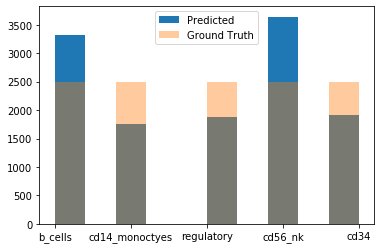

In [8]:
# Plot histogram
plt.hist([ct_map[i] for i in scores], label='Predicted')
plt.hist(pdata_ds['celltype'], alpha=0.4, label='Ground Truth')
plt.legend()

### Visualize Results Part 2

We can visualize our data better by reducing the dimensions of our scRNA-seq matrix and plotting it. We'll do this using umap.

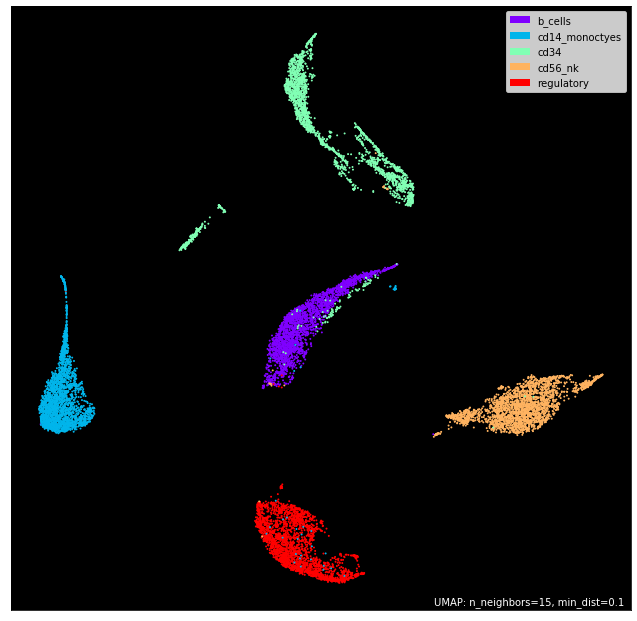

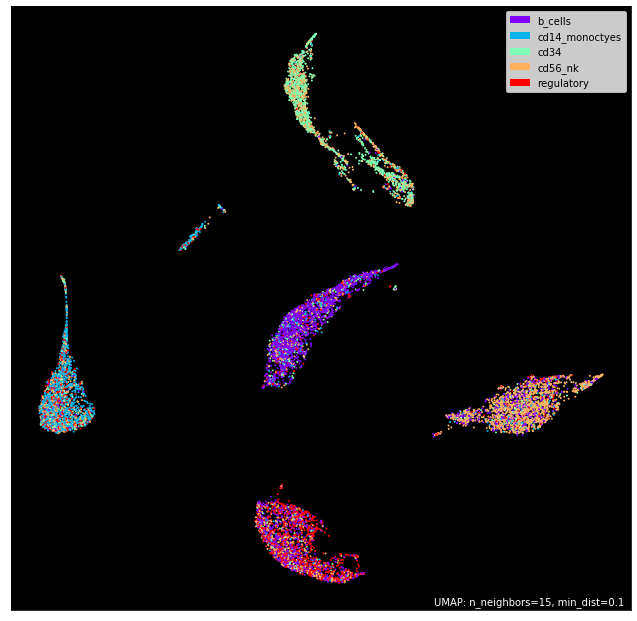

In [9]:
# reduce dimensions to 50 via SVD to reduce noise
lsa_matrix = utils.lsa(expr_ds)

# feed SVD results into UMAP
mapper = umap.UMAP().fit(lsa_matrix)
coords = mapper.fit_transform(lsa_matrix)

# Plot results versus ground truth and prediction
umap.plot.points(mapper, labels=np.array(pdata_ds['celltype']), theme='fire')
umap.plot.points(mapper, labels=np.array(np.array([ct_map[i] for i in scores])), theme='fire')

### Improving Classifcation: Data Integration

We can further improve our classification by merging both domain knowledge (scores from gene2vec) and data-driven approaches. In our case, it's appearent that UMAP clusters each group of cell-types very well. We can take advantage of this by taking a neighborhood voting approach to improve classifcation. Basically each single cells identity will be deteremined by it's only naive-classifcation and it's N-nearest-Neighbor.

As you can see our results increase drastically when we integrate data.


A data-integration approach yields an improved accuracy of 0.8652


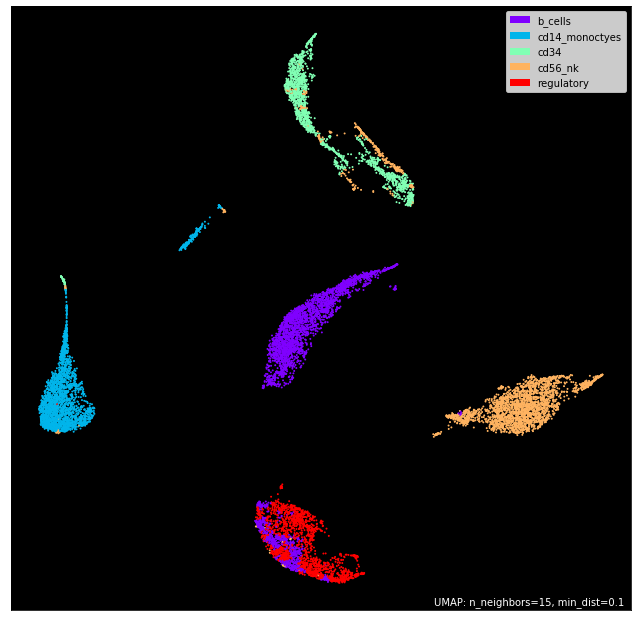

In [10]:
# get naive celltype from our score calculations
naive_ct = np.array([ct_map[i] for i in scores])

# calculate l2dist across all celltypes from umap
l2_coords = utils.l2_norm(coords)

# NN-search
nn_ct = utils.NN_search(l2_coords, 50, naive_ct)

new_acc = utils.accuracy_score(nn_ct, pdata_ds['celltype'])
print("A data-integration approach yields an improved accuracy of", new_acc)

# plot new results
umap.plot.points(mapper, labels=np.array(nn_ct), theme='fire')